In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
data1a = np.load('part1a.npz')

In [29]:
N = data1a['N'].sum()
S_0 = data1a['Svc_0_pmf'].flatten()*(N.reshape(1)[0]).flatten()
I_c0 = data1a['Ic_0']
R_0 = np.array([0])
t = np.linspace(0,120,240)

initial_vec = np.concatenate([S_0,I_c0,R_0])
betas = np.linspace(0.1,1,16).reshape(4,4)
gamma = data1a['gamma'].reshape(1)[0]


In [30]:
#solution

def SIR_model(t, Y, betas, gamma):
    S_vector=Y[:16].reshape(4,4)
    I_vector=Y[16:20]
    R=Y[20]
    
    # (-(-(np.sum(betas, axis = 1)*np.sum(S_vector, axis = 1)*np.sum(I_vector)))
    
    dSvc_dt= (-(betas*S_vector*np.sum(I_vector))/N)
    dIc_dt= (-np.sum(dSvc_dt, axis = 1) - gamma*I_vector).flatten()
    dR_dt= gamma*np.sum(I_vector).flatten()
    
    RHS_vector= np.concatenate([dSvc_dt.flatten(), dIc_dt, dR_dt])

    return RHS_vector

In [31]:
from scipy.integrate import solve_ivp

soln_obj = solve_ivp(SIR_model, (t[0],t[-1]), initial_vec, 
                     args = (betas, gamma), dense_output = True)

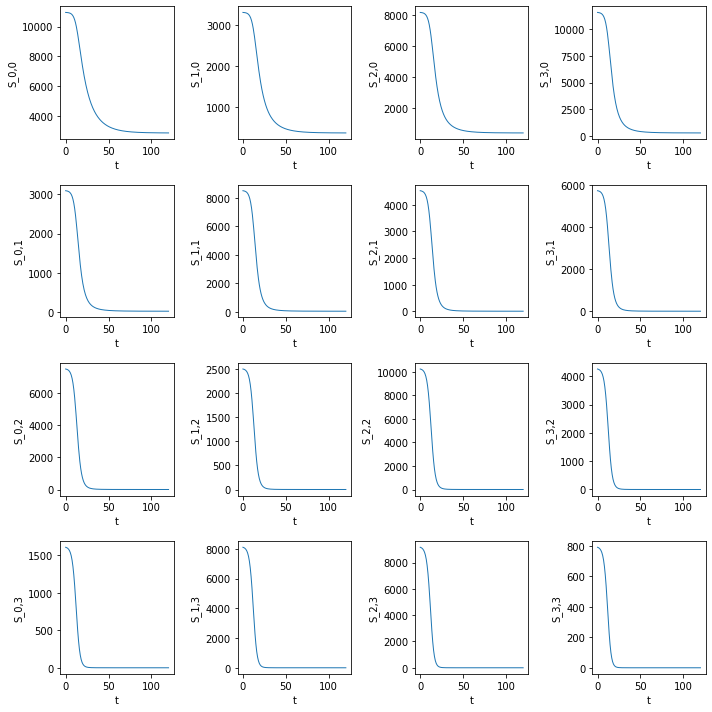

In [32]:
# S_v,c's
plt.figure(figsize=(10,10))

for i in range(0,16):
    
    plt.subplot(4,4, i+1)
    
    plt.plot(t, soln_obj.sol(t)[i], linewidth=1)
    plt.xlabel("t")
    plt.ylabel(f'S_{i%4},{i//4}').set_rotation(90)
    

plt.tight_layout()
plt.show()


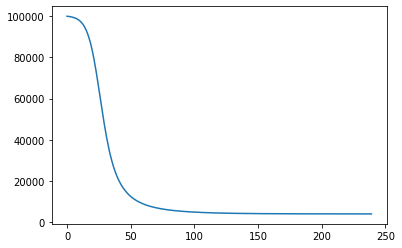

In [33]:
plt.plot(soln_obj.sol(t)[:16].sum(axis=0))

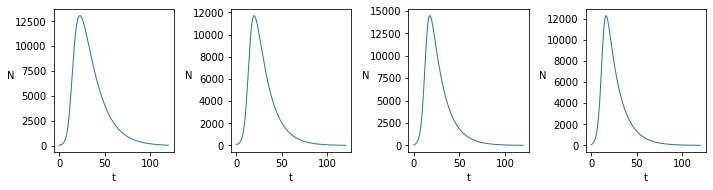

In [34]:
#I_t's

plt.figure(figsize=(10,10))

for i in range(0,4):
    
    plt.subplot(4,4, i+1)
    
    plt.plot(t, soln_obj.sol(t)[i + 16], linewidth=1)
    plt.xlabel("t")
    plt.ylabel("N").set_rotation(0)
    
plt.tight_layout()
plt.show()

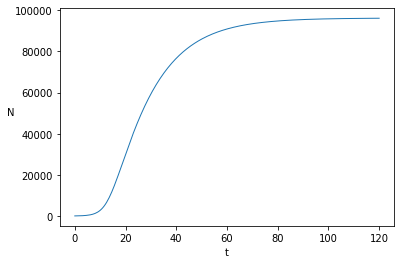

In [35]:
# R
plt.plot(t, soln_obj.sol(t)[-1], linewidth=1)
plt.xlabel("t")
plt.ylabel("N").set_rotation(0)